In [ ]:


class SmaCrossStrategy(bt.Strategy):
    params = dict(
        sma_short_period=10,
        sma_long_period=50,
    )

    def __init__(self):
        self.sma_short = bt.ind.SMA(period=self.p.sma_short_period)
        self.sma_long = bt.ind.SMA(period=self.p.sma_long_period)
        self.crossover = bt.ind.CrossOver(self.sma_short, self.sma_long)

    def next(self):
        if not self.position:
            if self.crossover > 0:
                self.buy()
        elif self.crossover < 0:
            self.sell()

In [2]:
import backtrader as bt
import yfinance as yf
import pandas as pd

data = yf.download('TSLA', start='2024-06-01', end='2025-02-13')
# Flatten the MultiIndex columns by taking their first level
data.columns = [col[0] for col in data.columns]
# Select columns required by Backtrader and convert them to lowercase
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.columns = [col.lower() for col in data.columns]
data_bt = bt.feeds.PandasData(dataname=data)

[*********************100%***********************]  1 of 1 completed


In [4]:
cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCrossStrategy)
cerebro.adddata(data_bt)
cerebro.broker.set_cash(100000.0)
cerebro.broker.setcommission(commission=0.001)  # handling fee to 0.1%
cerebro.broker.set_slippage_perc(0.001)      # slippage to 0.1%  
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown') 
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
cerebro.run()


In [5]:
# Print out the final result
results = cerebro.run()
sharpe = results[0].analyzers.sharpe.get_analysis()
drawdown = results[0].analyzers.drawdown.get_analysis()
trade_analyzer = results[0].analyzers.trade_analyzer.get_analysis()

print(f"Final net asset value: {cerebro.broker.getvalue():.2f}")
print(f"Sharpe Ratio: {sharpe['sharperatio']:.2f}")
print(f"Maximum drawdown: {drawdown.max.drawdown:.2f}%")
print(f"Total trade times: {trade_analyzer.total.closed}")

Final net asset value: 100108.02
Sharpe Ratio: -13.30
Maximum drawdown: 0.10%
Total trade times: 2


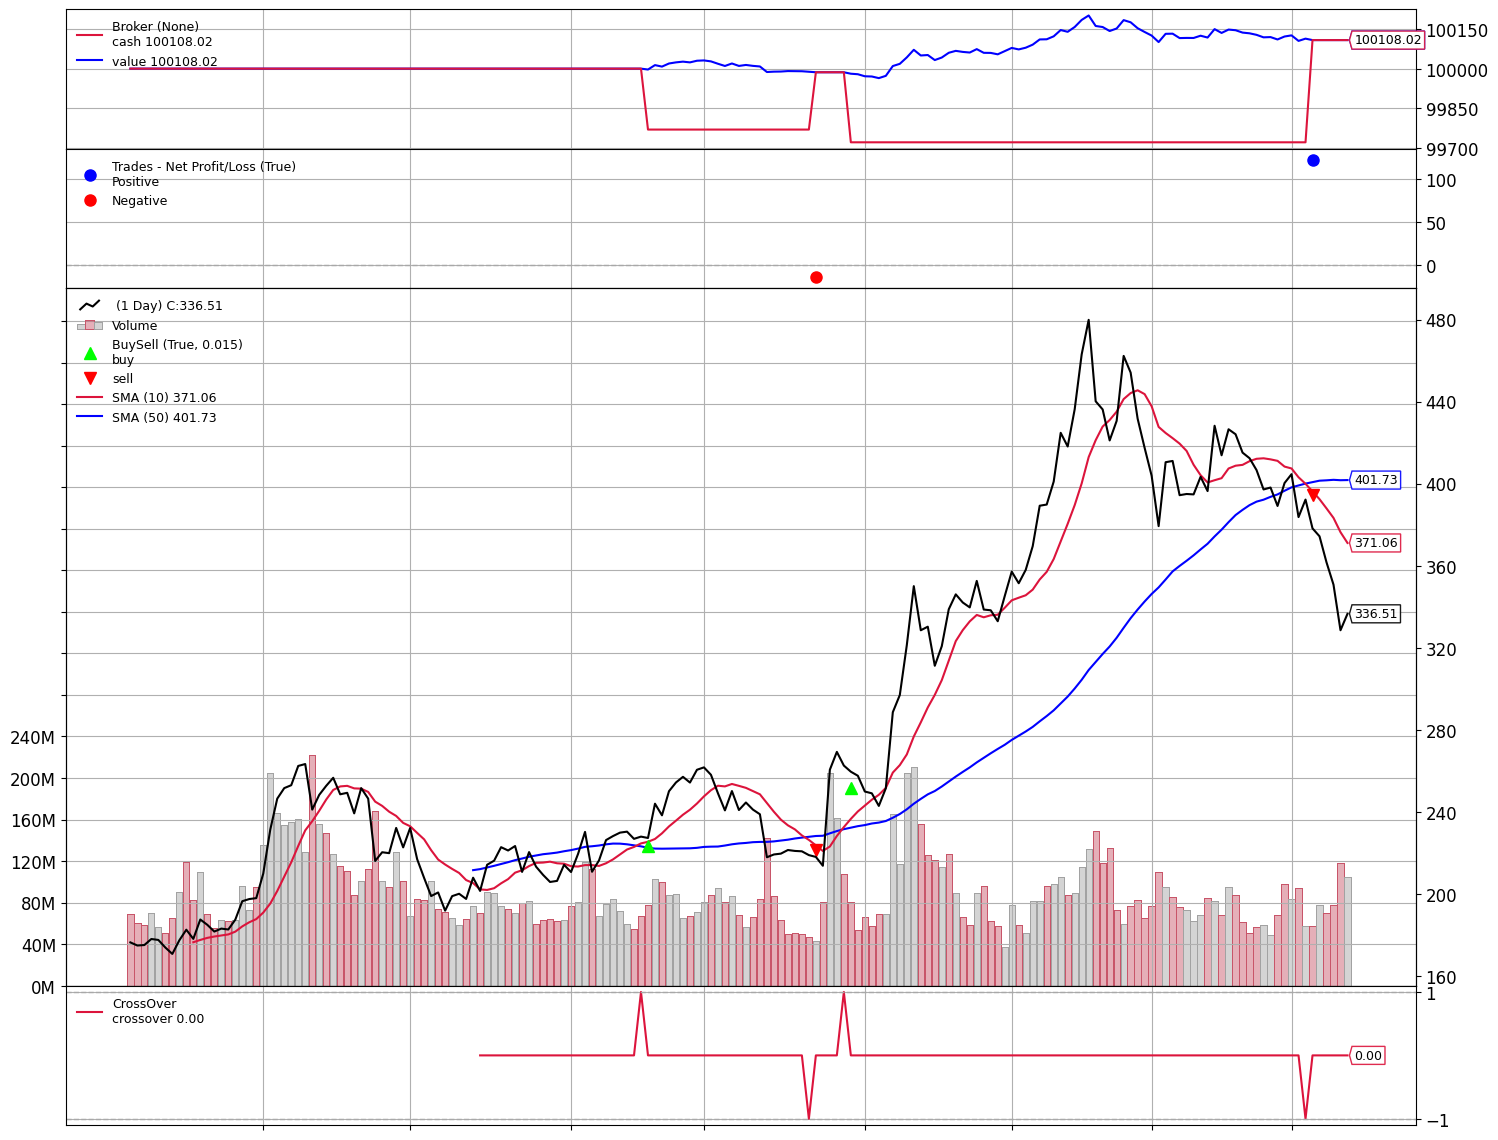

[[<Figure size 1500x1200 with 5 Axes>]]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
cerebro.plot(iplot = False)

In [13]:
class MomentumStrategy(bt.Strategy):
    # Define the strategy parameters; here 'period' is the lookback period for the momentum indicator
    params = (('period', 10),)

    def __init__(self):
        # Create a Momentum indicator using the close prices with the defined period
        self.momentum = bt.indicators.Momentum(self.data.close, period=self.params.period)
        # Store initial portfolio value to compare performance later
        self.starting_value = self.broker.getvalue()
        # List to record the portfolio value at each step for performance analysis
        self.daily_values = []

    def next(self):
        # If no position is currently held, consider entering the market
        if not self.position:
            # Go long if the momentum indicator suggests upward momentum
            if self.momentum[0] > 0:
                self.buy()
        # If already in a position, exit if momentum turns non-positive
        elif self.momentum[0] <= 0:
            self.sell()

        # Append the current portfolio value to track daily performance
        self.daily_values.append(self.broker.getvalue())

In [23]:
import pandas as pd
import numpy as np
cerebro = bt.Cerebro()
cerebro.addstrategy(MomentumStrategy)

cerebro.adddata(data_bt)

cerebro.broker.setcash(100000)

print(f'Initial capital: {cerebro.broker.getvalue():.2f}')
results = cerebro.run()
print(f'Funds after backtesting: {cerebro.broker.getvalue():.2f}')

strategy = results[0]

portfolio_values = pd.Series(strategy.daily_values)
returns = portfolio_values.pct_change().dropna()

annual_return = returns.mean() * 252
annual_volatility = returns.std() * np.sqrt(252)
risk_free_rate = 0.01 
sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility

cumulative_returns = (1 + returns).cumprod()
drawdown = cumulative_returns / cumulative_returns.cummax() - 1
max_drawdown = drawdown.min()

print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Max drawdown: {max_drawdown:.2%}')


Initial capital: 100000.00
Funds after backtesting: 100192.08
Sharpe Ratio: -4.55
Max drawdown: -0.08%


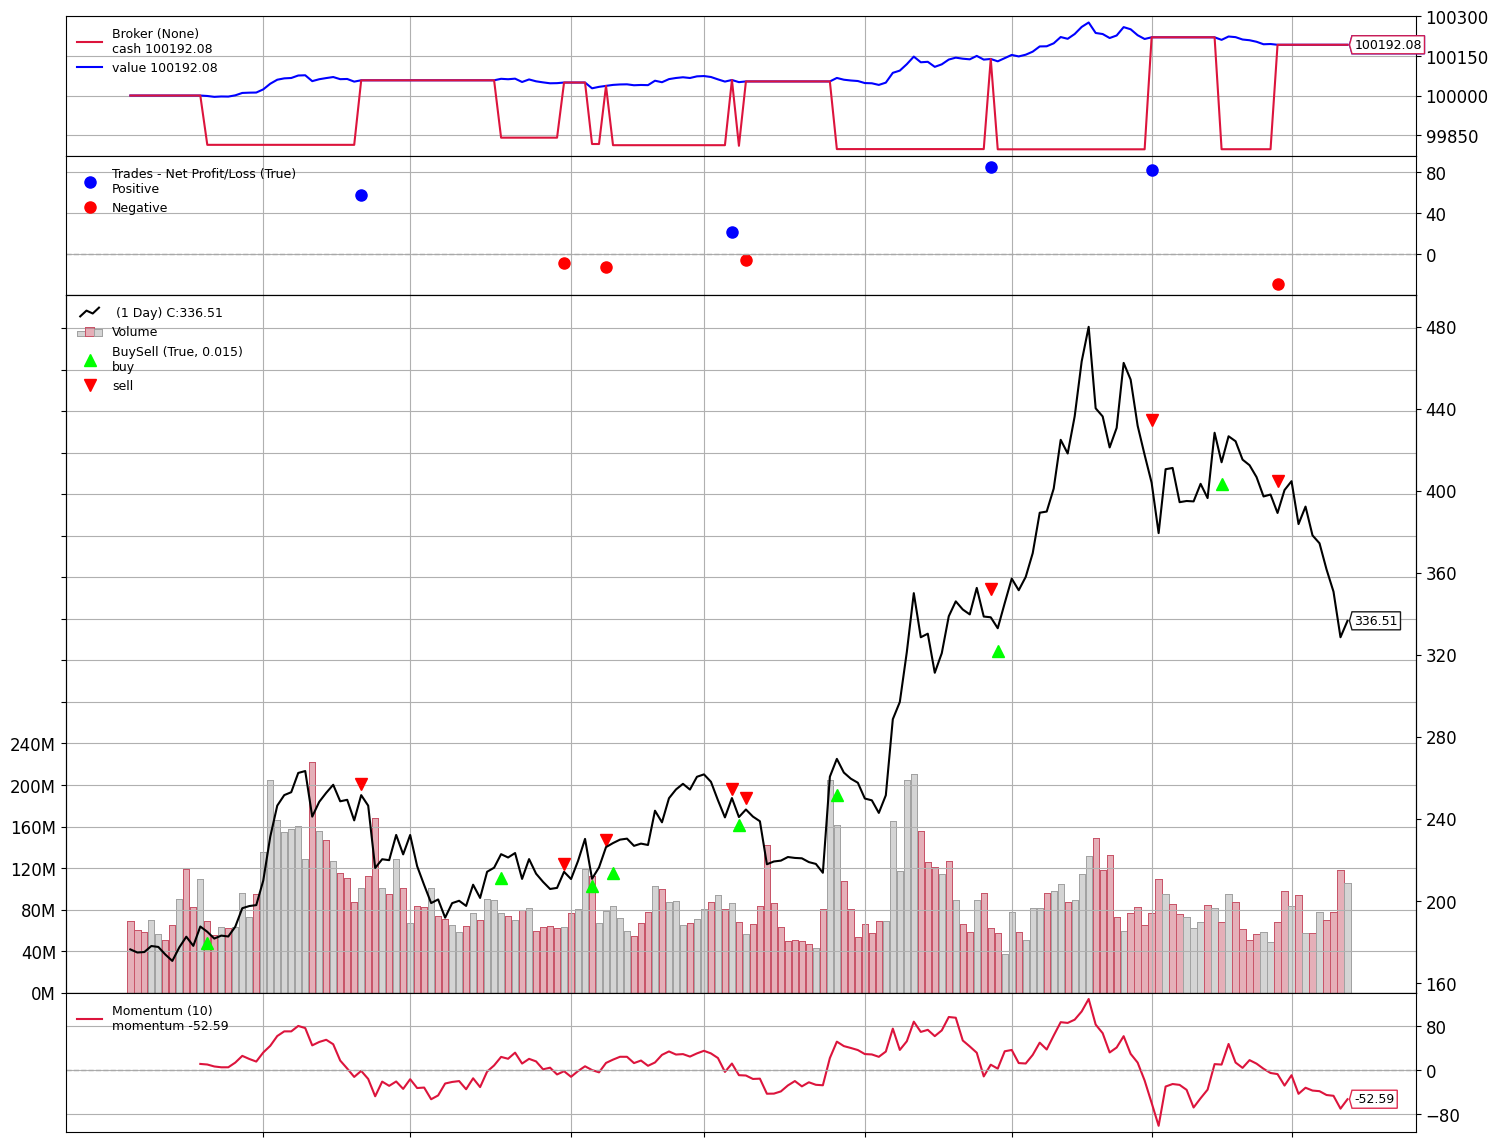

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams.update({'font.size': 12})
img = cerebro.plot(iplot = False)

In [29]:
class MeanReversionStrategy(bt.Strategy):
    params = (('period', 20), ('zscore_entry', 1), ('zscore_exit', 0))

    def __init__(self):
        self.moving_avg = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.period)
        self.stddev = bt.indicators.StandardDeviation(self.data.close, period=self.params.period)
        self.zscore = None
        self.daily_values = []

    def next(self):
        # Ensure there are enough data points to calculate zscore
        if len(self.data) >= self.params.period:
            # Calculate z-score
            self.zscore = (self.data.close[0] - self.moving_avg[0]) / (self.stddev[0] + 1e-8)  # Add a small value to avoid division by zero

            # If no position is currently held, consider entering the market
            if not self.position:
                # Go long if the zscore is below the entry threshold
                if self.zscore < -self.params.zscore_entry:
                    self.buy()
            # If already in a position, exit if zscore crosses the exit threshold
            elif self.zscore >= self.params.zscore_exit:
                self.sell()

        # Append the current portfolio value to track daily performance
        self.daily_values.append(self.broker.getvalue())

cerebro = bt.Cerebro()
cerebro.addstrategy(MeanReversionStrategy)

cerebro.adddata(data_bt)

cerebro.broker.setcash(100000)

print(f'Initial capital: {cerebro.broker.getvalue():.2f}')
results = cerebro.run()
print(f'Funds after backtesting: {cerebro.broker.getvalue():.2f}')

strategy = results[0]

portfolio_values = pd.Series(strategy.daily_values)
returns = portfolio_values.pct_change().dropna()

annual_return = returns.mean() * 252
annual_volatility = returns.std() * np.sqrt(252)
risk_free_rate = 0.01  # Risk-free rate set to 1%
sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility

# Calculate maximum drawdown
cumulative_returns = (1 + returns).cumprod()
drawdown = cumulative_returns / cumulative_returns.cummax() - 1
max_drawdown = drawdown.min()

print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Max drawdown: {max_drawdown:.2%}')


Initial capital: 100000.00
Funds after backtesting: 100003.89
Sharpe Ratio: -9.03
Max drawdown: -0.09%


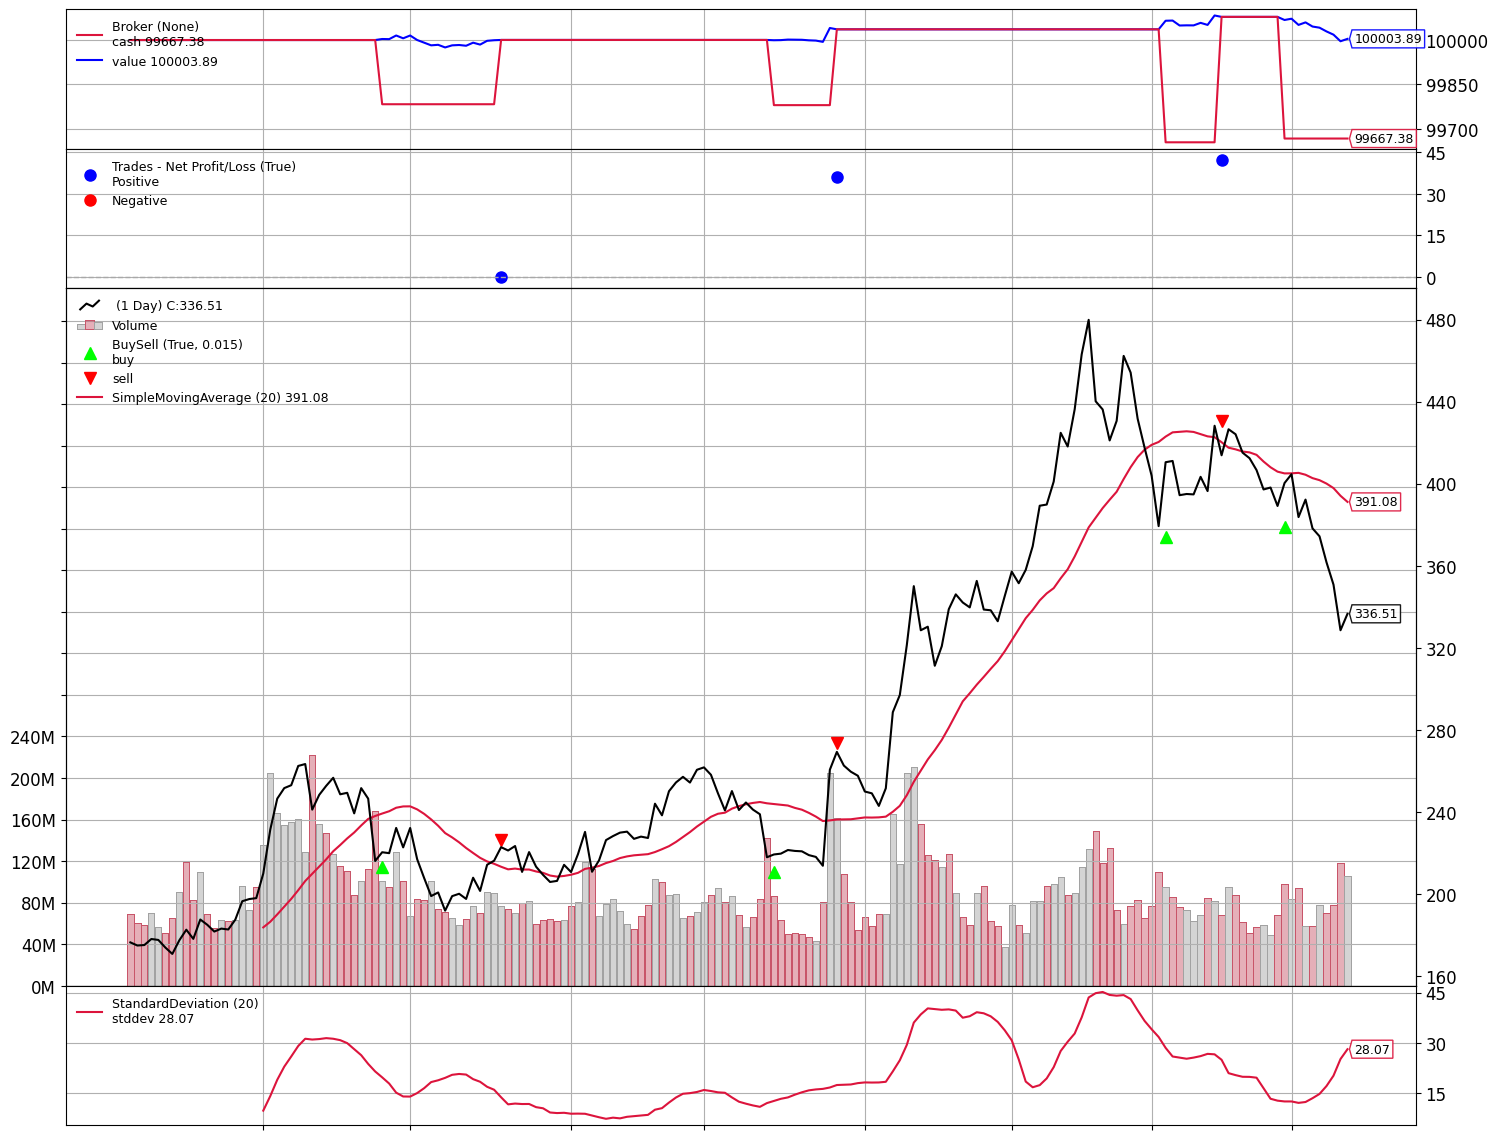

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams.update({'font.size': 12})
img = cerebro.plot(iplot = False)